In [2]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import config
import matplotlib.pyplot as plt

Set model and project path

In [3]:
model = 'Wav2Vec2-final-baseline-noisy-hard-40.19'
PATH = '/home/kriti/ambivalent/'

Read the results CSV file generated by test.sh

In [4]:
df = pd.read_csv(PATH + model + '.csv')

Overall Classification report

In [5]:
print(classification_report(df['ground-truth'], df['prediction']))

              precision    recall  f1-score   support

         ang       0.47      0.44      0.45       170
         exc       0.56      0.36      0.44       299
         fru       0.40      0.40      0.40       381
         hap       0.26      0.15      0.19       143
         neu       0.44      0.53      0.48       384
         sad       0.47      0.67      0.55       245

    accuracy                           0.44      1622
   macro avg       0.43      0.42      0.42      1622
weighted avg       0.44      0.44      0.44      1622



Gender-wise classification report

In [6]:
male_df = pd.DataFrame(columns=df.columns)
female_df = pd.DataFrame(columns=df.columns)

idx1 = 0
idx2 = 0

for i in range(len(df)):
    speaker = df.loc[i, 'wavfile'].split('_')[-1]
    if 'F' in speaker:
        female_df = pd.concat([female_df, pd.DataFrame([df.iloc[i]])], ignore_index=True)
    elif 'M' in speaker:
        male_df = pd.concat([male_df, pd.DataFrame([df.iloc[i]])], ignore_index=True)


Results for male utterances

In [29]:
print(classification_report(male_df['ground-truth'], male_df['prediction']))

              precision    recall  f1-score   support

         ang       0.32      0.41      0.36        92
         exc       0.41      0.19      0.26       217
         fru       0.33      0.38      0.35       220
         hap       0.16      0.14      0.15        66
         neu       0.28      0.45      0.34       163
         sad       0.49      0.31      0.38       113

    accuracy                           0.32       871
   macro avg       0.33      0.31      0.31       871
weighted avg       0.34      0.32      0.32       871



Results for female utterances

In [86]:
print(classification_report(female_df['ground-truth'], female_df['prediction']))

              precision    recall  f1-score   support

         ang       0.46      0.51      0.48        78
         exc       0.48      0.45      0.47        82
         fru       0.40      0.60      0.48       161
         hap       0.25      0.10      0.15        77
         neu       0.50      0.40      0.44       221
         sad       0.67      0.70      0.68       132

    accuracy                           0.48       751
   macro avg       0.46      0.46      0.45       751
weighted avg       0.48      0.48      0.47       751



Confusion matrix for full test set

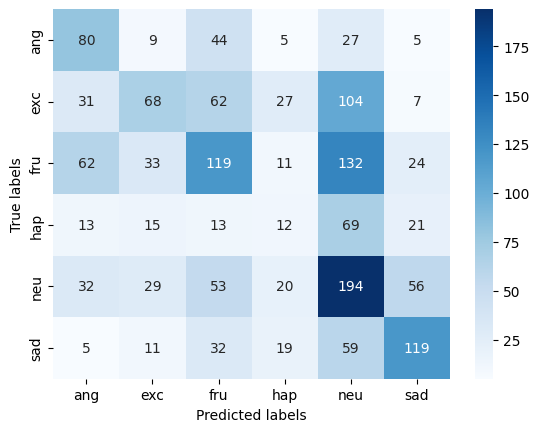

In [170]:
cm = confusion_matrix(df['ground-truth'], df['prediction'], labels=config.labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(config.labels)
ax.yaxis.set_ticklabels(config.labels)
plt.savefig('/home/kriti/ambivalent/images/'+ model + '-cm.png')

ECE and cross entropy computation

In [171]:
import torch
from torch import nn, Tensor

def expected_calibration_error_multiclass(y_true, y_prob, num_bins=10):
    """
    Calculate the Expected Calibration Error (ECE) for a probabilistic multiclass classification model.

    Parameters:
        y_true (numpy array): True labels (ground truth) as integers (0 to num_classes-1).
        y_prob (numpy array): Predicted probabilities for each class (shape: [n_samples, num_classes]).
        num_bins (int): Number of bins to divide the probability range into (default is 10).

    Returns:
        float: Expected Calibration Error (ECE) value.
    """
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    # Calculate confidence bins
    bin_boundaries = np.linspace(0, 1, num_bins + 1)

    # Initialize variables to accumulate values for ECE calculation
    ece = 0.0
    bin_correct = np.zeros(num_bins)
    bin_total = np.zeros(num_bins)

    # Calculate predicted classes for each sample
    y_pred = np.argmax(y_prob, axis=1)

    # Calculate the confidence of the predictions (maximum probability)
    confidences = np.max(y_prob, axis=1)

    # Iterate over each prediction and calculate ECE
    for i in range(num_bins):
        # Find indices of predictions falling into the current bin
        bin_indices = np.logical_and(confidences >= bin_boundaries[i], confidences < bin_boundaries[i + 1])

        # Count total number of predictions in the bin for each class
        bin_total[i] = np.sum(bin_indices)

        # Calculate the accuracy for this bin for each class
        if bin_total[i] > 0:
            bin_accuracy = np.mean(y_pred[bin_indices] == y_true[bin_indices])
            bin_correct[i] = bin_accuracy * bin_total[i]
            ece += np.abs(bin_accuracy - np.mean(confidences[bin_indices])) * bin_total[i]

    # Normalize ECE by the total number of predictions
    ece /= np.sum(bin_total)

    return ece

class CrossEntropy(nn.Module):
    """
    The new implementation of cross entropy using two distributions.

    Inputs: two tensors for predictions and target.
        1. predicted probability distributions of shape (N, C)
        2. target probability distributions of shape (N, C)

    Outputs: scalar tensor, normalised by the number of examples.
    """

    def __init__(self) -> None:
        super().__init__()

    def forward(self, y_pred: Tensor, y_true: Tensor, cur_time: int) -> Tensor:
        """one_hot=True, 
        Inputs:
            pred_probs: predictions of shape (N, C).
            target_probs: targets of shape (N, C).

        Outputs:
            Loss: a scalar tensor, normalised by N.
        """
        epsilon = 1e-15  # Small constant to avoid log(0)
    
        # Ensure y_pred and y_true have the same shape
        assert y_pred.shape == y_true.shape, "Shapes of y_pred and y_true must be the same."
    
        # Clip the predicted probabilities to avoid log(0)
        y_pred = torch.clamp(y_pred, epsilon, 1.0 - epsilon)
        
        # Compute the Cross Entropy Loss
        loss = - torch.sum(y_true * torch.log(y_pred), dim=1)
        avg_loss = torch.mean(loss)
        
        return avg_loss

pred_conf = []
for x in df['pred-conf']:
    pred_conf.append([float(num) for num in x[1:-2].split()])

gt_conf = []
for x in df['gt-conf']:
    gt_conf.append([float(num) for num in x[1:-2].split()])

soft_gt_conf = []
for x in df['soft-gt-conf']:
    soft_gt_conf.append([float(num) for num in x[1:-2].split()])

tensor_pred_conf = torch.Tensor(np.array(pred_conf))
tensor_gt_conf = torch.Tensor(np.array(gt_conf))
tensor_soft_gt_conf = torch.Tensor(np.array(soft_gt_conf))

print(pred_conf[:10])
print(gt_conf[:10])
cce_loss = CrossEntropy()
print("hard", expected_calibration_error_multiclass(y_true=np.argmax(tensor_gt_conf.numpy(), -1), y_prob=tensor_pred_conf.numpy()))
print("soft", expected_calibration_error_multiclass(y_true=np.argmax(tensor_gt_conf.numpy(), -1), y_prob=tensor_pred_conf.numpy()))
print("cce loss", cce_loss(tensor_pred_conf, tensor_soft_gt_conf, None))

[[0.01086753, 0.34533545, 0.1123322, 0.37581658, 0.12721041, 0.0284378], [0.00027126068, 0.99332833, 0.000472071, 0.0058548548, 3.4195098e-05, 3.9282037], [0.00285864, 0.3845856, 0.02719704, 0.28150284, 0.30334082, 0.000515], [0.44186017, 0.07386108, 0.44732672, 0.02980995, 0.00344121, 0.0037008], [0.49353647, 0.0161059, 0.47203496, 0.00245864, 0.01444297, 0.001421], [0.24667998, 0.00851739, 0.17773646, 0.00164868, 0.51594704, 0.0494703], [0.04165202, 0.04538671, 0.1730825, 0.4322041, 0.17277181, 0.1349028], [0.00332942, 0.8145623, 0.03310607, 0.00327674, 0.144588, 0.0011374], [0.01308724, 0.32131454, 0.08968232, 0.31359315, 0.25002193, 0.0123007], [0.98754382, 1.8289014e-06, 0.0086759264, 2.775248e-06, 0.00055880839, 3.2167598]]
[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.

Get top flips during training (total and gender-wise) for BiLSTM and Wav2Vec2 model

In [87]:
import pandas as pd
from tqdm import tqdm
df = pd.read_csv('/home/kriti/ambivalent/train-predictions-BiLSTM-0.7-6.csv')

def get_flips(df):
    top_swaps = {}
    top_correct_swaps = {}
    for i in range(len(df)):
        old_l = df.loc[i, 'old_label']
        new_l = df.loc[i, 'new_label']
        gt = df.loc[i, 'gt_label']
        if old_l != new_l:
            if new_l == gt:
                if (old_l, new_l) not in top_correct_swaps:
                    top_correct_swaps[(old_l, new_l)] = 1
                else:
                    top_correct_swaps[(old_l, new_l)] += 1
            if (old_l, new_l) not in top_swaps:
                top_swaps[(old_l, new_l)] = 1
            else:
                top_swaps[(old_l, new_l)] += 1

    return top_swaps, top_correct_swaps

top_swaps, top_correct_swaps = get_flips(df)
print("top swaps", sorted(top_swaps.items(), key=lambda x: x[1], reverse=True))
print("top correct swaps", sorted(top_correct_swaps.items(), key=lambda x: x[1], reverse=True))

male_df = pd.DataFrame(columns=df.columns)
female_df = pd.DataFrame(columns=df.columns)

print("Splitting dfs")

for i in tqdm(range(len(df))):
    speaker = df.loc[i, 'wavfile'].split('_')[-1]
    if 'F' in speaker:
        female_df = pd.concat([female_df, pd.DataFrame([df.iloc[i]])], ignore_index=True)
    elif 'M' in speaker:
        male_df = pd.concat([male_df, pd.DataFrame([df.iloc[i]])], ignore_index=True)

top swaps [(('ang', 'fru'), 574), (('neu', 'sad'), 463), (('fru', 'neu'), 426), (('fru', 'ang'), 380), (('fru', 'sad'), 345), (('neu', 'fru'), 199), (('hap', 'exc'), 190), (('exc', 'hap'), 182), (('fru', 'exc'), 172), (('hap', 'sad'), 158), (('exc', 'neu'), 157), (('sad', 'fru'), 154), (('ang', 'neu'), 154), (('exc', 'fru'), 147), (('sad', 'neu'), 112), (('hap', 'neu'), 111), (('ang', 'sad'), 106), (('neu', 'hap'), 83), (('fru', 'hap'), 79), (('sad', 'ang'), 69), (('neu', 'exc'), 68), (('ang', 'exc'), 56), (('exc', 'sad'), 54), (('sad', 'exc'), 51), (('sad', 'hap'), 30), (('neu', 'ang'), 28), (('exc', 'ang'), 18), (('hap', 'fru'), 11), (('ang', 'hap'), 7), (('hap', 'ang'), 6)]
top correct swaps [(('ang', 'fru'), 283), (('fru', 'sad'), 233), (('neu', 'sad'), 224), (('fru', 'ang'), 170), (('fru', 'neu'), 152), (('hap', 'exc'), 126), (('exc', 'neu'), 75), (('neu', 'fru'), 63), (('sad', 'fru'), 57), (('exc', 'hap'), 49), (('hap', 'neu'), 43), (('ang', 'sad'), 39), (('sad', 'ang'), 28), (('

In [94]:
print("male df")
top_swaps, top_correct_swaps = get_flips(male_df)
print("top swaps", sorted(top_swaps.items(), key=lambda x: x[1], reverse=True))
print("top correct swaps", sorted(top_correct_swaps.items(), key=lambda x: x[1], reverse=True))

print("female df")
top_swaps, top_correct_swaps = get_flips(female_df)
print("top swaps", sorted(top_swaps.items(), key=lambda x: x[1], reverse=True))
print("top correct swaps", sorted(top_correct_swaps.items(), key=lambda x: x[1], reverse=True))

male df
top swaps [(('ang', 'fru'), 323), (('neu', 'sad'), 236), (('fru', 'neu'), 226), (('fru', 'sad'), 219), (('neu', 'fru'), 149), (('fru', 'ang'), 144), (('fru', 'exc'), 116), (('hap', 'exc'), 102), (('exc', 'neu'), 101), (('exc', 'fru'), 91), (('ang', 'neu'), 83), (('exc', 'hap'), 81), (('sad', 'fru'), 78), (('hap', 'neu'), 76), (('hap', 'sad'), 71), (('ang', 'sad'), 61), (('sad', 'neu'), 61), (('fru', 'hap'), 47), (('neu', 'exc'), 44), (('exc', 'sad'), 38), (('neu', 'hap'), 37), (('sad', 'ang'), 30), (('ang', 'exc'), 28), (('sad', 'hap'), 16), (('sad', 'exc'), 12), (('exc', 'ang'), 11), (('ang', 'hap'), 6), (('hap', 'fru'), 5), (('neu', 'ang'), 4), (('hap', 'ang'), 4)]
top correct swaps [(('ang', 'fru'), 152), (('fru', 'sad'), 130), (('neu', 'sad'), 95), (('hap', 'exc'), 72), (('fru', 'neu'), 64), (('fru', 'ang'), 60), (('neu', 'fru'), 49), (('exc', 'neu'), 47), (('sad', 'fru'), 36), (('hap', 'neu'), 33), (('ang', 'sad'), 28), (('exc', 'fru'), 24), (('exc', 'hap'), 20), (('sad', 

In [97]:
top_swaps = {}
top_correct_swaps = {}
df = pd.read_csv('/home/kriti/ambivalent/train-predictions-Wav2Vec2-0.7-6.csv')

def get_flips(df):
    top_swaps = {}
    top_correct_swaps = {}
    for i in range(len(df)):
        old_l = df.loc[i, 'old_label']
        new_l = df.loc[i, 'new_label']
        gt = df.loc[i, 'gt_label']
        if old_l != new_l:
            if new_l == gt:
                if (old_l, new_l) not in top_correct_swaps:
                    top_correct_swaps[(old_l, new_l)] = 1
                else:
                    top_correct_swaps[(old_l, new_l)] += 1
            if (old_l, new_l) not in top_swaps:
                top_swaps[(old_l, new_l)] = 1
            else:
                top_swaps[(old_l, new_l)] += 1

    return top_swaps, top_correct_swaps

top_swaps, top_correct_swaps = get_flips(df)
print("top swaps", sorted(top_swaps.items(), key=lambda x: x[1], reverse=True))
print("top correct swaps", sorted(top_correct_swaps.items(), key=lambda x: x[1], reverse=True))

male_df = pd.DataFrame(columns=df.columns)
female_df = pd.DataFrame(columns=df.columns)

print("Splitting dfs")

for i in tqdm(range(len(df))):
    speaker = df.loc[i, 'wavfile'].split('_')[-1]
    if 'F' in speaker:
        female_df = pd.concat([female_df, pd.DataFrame([df.iloc[i]])], ignore_index=True)
    elif 'M' in speaker:
        male_df = pd.concat([male_df, pd.DataFrame([df.iloc[i]])], ignore_index=True)

top swaps [(('ang', 'fru'), 171), (('fru', 'ang'), 94), (('neu', 'fru'), 62), (('fru', 'neu'), 45), (('sad', 'fru'), 38), (('exc', 'hap'), 29), (('hap', 'sad'), 28), (('fru', 'sad'), 28), (('hap', 'exc'), 24), (('neu', 'sad'), 24), (('exc', 'fru'), 22), (('exc', 'neu'), 22), (('ang', 'sad'), 21), (('sad', 'neu'), 14), (('neu', 'exc'), 11), (('ang', 'neu'), 8), (('hap', 'neu'), 8), (('exc', 'ang'), 7), (('fru', 'exc'), 6), (('sad', 'ang'), 6), (('ang', 'exc'), 6), (('hap', 'ang'), 5), (('hap', 'fru'), 4), (('fru', 'hap'), 2), (('neu', 'hap'), 2)]
top correct swaps [(('ang', 'fru'), 98), (('fru', 'ang'), 63), (('fru', 'neu'), 30), (('neu', 'fru'), 26), (('hap', 'exc'), 23), (('fru', 'sad'), 23), (('exc', 'neu'), 19), (('ang', 'sad'), 18), (('sad', 'fru'), 16), (('neu', 'exc'), 10), (('exc', 'fru'), 9), (('exc', 'hap'), 9), (('neu', 'sad'), 6), (('sad', 'neu'), 5), (('sad', 'ang'), 3), (('fru', 'exc'), 1), (('ang', 'exc'), 1), (('exc', 'ang'), 1)]
Splitting dfs


100%|██████████| 144820/144820 [02:46<00:00, 867.45it/s]


In [99]:
print("male df")
top_swaps, top_correct_swaps = get_flips(male_df)
print("top swaps", sorted(top_swaps.items(), key=lambda x: x[1], reverse=True))
print("top correct swaps", sorted(top_correct_swaps.items(), key=lambda x: x[1], reverse=True))

print("female df")
top_swaps, top_correct_swaps = get_flips(female_df)
print("top swaps", sorted(top_swaps.items(), key=lambda x: x[1], reverse=True))
print("top correct swaps", sorted(top_correct_swaps.items(), key=lambda x: x[1], reverse=True))

male df
top swaps [(('ang', 'fru'), 100), (('fru', 'ang'), 34), (('fru', 'neu'), 25), (('neu', 'fru'), 23), (('ang', 'sad'), 17), (('sad', 'fru'), 13), (('neu', 'sad'), 13), (('exc', 'hap'), 13), (('exc', 'fru'), 12), (('hap', 'exc'), 12), (('fru', 'sad'), 10), (('neu', 'exc'), 10), (('exc', 'neu'), 9), (('hap', 'sad'), 8), (('sad', 'neu'), 8), (('hap', 'neu'), 7), (('hap', 'ang'), 5), (('exc', 'ang'), 5), (('sad', 'ang'), 5), (('ang', 'exc'), 4), (('hap', 'fru'), 3), (('ang', 'neu'), 3), (('fru', 'exc'), 2)]
top correct swaps [(('ang', 'fru'), 53), (('fru', 'ang'), 18), (('fru', 'neu'), 17), (('ang', 'sad'), 16), (('hap', 'exc'), 12), (('neu', 'fru'), 11), (('neu', 'exc'), 10), (('fru', 'sad'), 7), (('sad', 'fru'), 6), (('exc', 'neu'), 6), (('exc', 'fru'), 5), (('exc', 'hap'), 5), (('neu', 'sad'), 2), (('sad', 'ang'), 2), (('sad', 'neu'), 2), (('fru', 'exc'), 1), (('ang', 'exc'), 1), (('exc', 'ang'), 1)]
female df
top swaps [(('ang', 'fru'), 71), (('fru', 'ang'), 60), (('neu', 'fru'),